#### 2017/2018 Semester 2, Week 12 
__CS5339 Theory and Algorithm of Machine Learning__<br>
__Prof Lee Wee Sun__<br>
__Wang Shu__<br>
__Student ID: A0105534N__<br>


## Singapore Housing Prices Prediction<br>

## Objective

The goal of this Kaggle challenge is to examine historical housing transactions in Singapore in training datasets and to get predications for translations in testing datasets, which should be as close to actual transaction prices as possible. <br>

There are different types of housing in Singapore. The vast majority (more than 80%) of Singaporeans live in public housing developed by Housing and Development Board (HDB). These 99-year leasehold flats are a popular choice as they meet the growing needs of many residents — an affordable yet high-quality house they can own. Executive Condominiums is another type of public housing, but it shares the same amenities and facilities as with private condominiums but there are restrictions one must follow. In addition to public housing, there is private housing. These developments are commonly freehold but there are instances where they are 99-year or 999-year leasehold. There are different sub types among private housing such as apartment, condominium, landed property etc. <br>

Since public housing and private housing has different characteristics, the training datasets of private housing (private_train.csv) and public housing (hdb_train.csv) will be examined and modelled independently. 

## Data Exploration and Preprocessing


### Target Variable: price, resale_price

The __'price'__ in the private housing dataset is highly skewed with Skewness 18.042802 and Kurtosis 1275.152772, as such we apply $log(1+x)$ to all the price values. After applying the log transforamtion, we can check its distribution via density plot. 

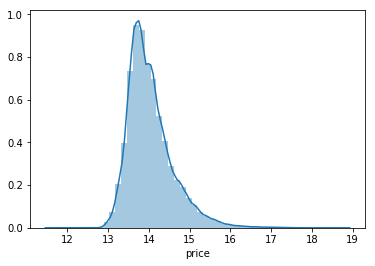

In [136]:
sns.distplot(train_feature['price'])
plt.show()

While for HDB dataset, the Skewness and Kurtosis for __'resale_price'__ are 1.144502 and 1.356704 respectively. As such we will use the values directly without log transformation. 

### Numberic Variables
The raw dataset of private housing contain numeric variables such as __['floor_area_sqm','latitude', 'longitude', 'floor_num', 'unit_num']__. While __'floor_area_sqm'__ is straightfoward, the geolocation data appeas to be more abstract. To better understand the mearning of the geolocation values, we will try to visualize these data. From the plot we can see that it is consistent with our common understanding that certral region tend to have higher housing price.

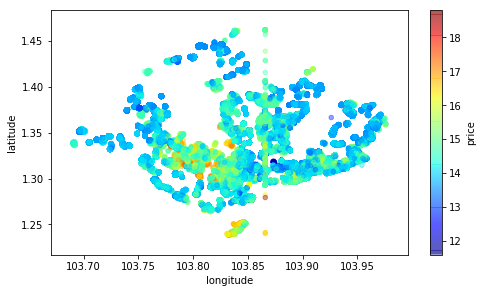

In [137]:
train_feature.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    c="price", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False,figsize=(8, 4.5))
plt.legend()
plt.show()

For numerical variables, we will also need to check its skewness. For private housing data, we have:

In [185]:
numeric_feats = condo_train_data.dtypes[condo_train_data.dtypes != "object"].index
skewed_feats = condo_train_data[numeric_feats].apply(lambda x: (x.dropna()).skew()).sort_values(ascending=False) #compute skewness
skewness = pd.DataFrame({'Skew' :skewed_feats})
print(skewness.head(10))

                         Skew
latitude         1.865923e+02
unit_num         5.712973e+01
price            1.804280e+01
floor_area_sqm   1.343489e+01
floor_num        1.860412e+00
index           -8.721204e-16
postal_sector   -7.900935e-02
postal_code     -9.749169e-02
postal_district -1.786975e-01
longitude       -1.817115e+02


As such we will need to perform $log(1+x)$ to the highly skewed variables.
Similarly, for HDB dataset, we get numerical variables __['floor_area_sqm','latitude', 'longitude', 'floor']__ and we will perform skewness check for the variables.

### Categorical Variables

The private housing dataset contains 7 categorical variables with object types, namely __['project_name', 'address', 'type_of_land', 'area', 'region', 'property_type', 'type_of_sale']__. In addition, we will convert __['postal_district', 'postal_sector', 'postal_code']__ to string and treat them as categorical variables. 

For standardization purpose, we will trim all the white space from __'project_name'__ values and covert all the characters to lower case (e.g.'THE SHORE RESIDENCES' will be convert to 'theshorereseidences'). In this way we will have 2952 unique project names. 

For __'address'__, since it normally contain street number, stree name and unit number, we will remove the street number and unit number parts, leaving only stree name (e.g. "81 Amber Road #16-06" will be convert to 'amberroad'). In this way we will have 3892 unique address roads. 

Since __'area'__,__'postal_district'__ and __'postal_sector'__ has overlap in coverage, to reduce the number of combinations, we ill joint these values and form a new variable __'location'__ (e.g. 'Marine Parade1543' is in Marine Parade area, postal district 15 and postal sector 43). In this way we obtained 139 unique location.

For categorical variables with small number of levels, Box plot is useful to visualize the relationship between different categories. For example: 

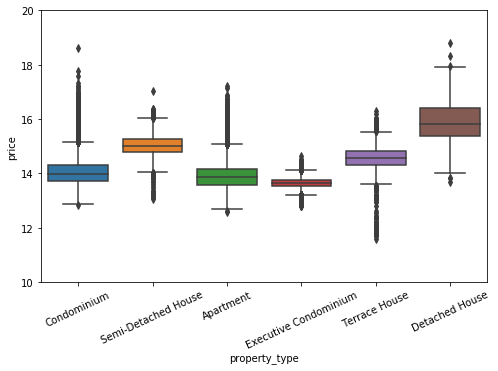

In [131]:
var = 'property_type'
data = pd.concat([train_feature['price'], train_feature[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 5))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=10, ymax=20)
plt.xticks(rotation=25)
plt.show()

For HDB dataset, we have 6 categorical variables: __['block', 'flat_model', 'flat_type', 'storey_range', 'street_name', 'town']__. We wil trim __'street_name'__ in the same way as processing private housing data. 

### Date Variables

In private housing dataset, we have three variables that contain date/time information, namey __['contract_date','completion_date','tenure','month']__. 
For analysis we will convert these variables from object type to datetime. In particular, __'tenure'__ contains two parts of information, one is the length of tenure, the other is the starting date of the tenure. Therefore from this column we can derive another two variabls __'tenure_start_datetime'__ and __'tenure_length'__ (details can be seen in __convert_datetime__ function. 

In [184]:
all_feature.head(3)[['contract_date','contract_datetime','completion_date','completion_datetime','tenure','tenure_length','tenure_start_datetime']]

,contract_date,contract_datetime,completion_date,completion_datetime,tenure,tenure_length,tenure_start_datetime
0,01-Jan-2010,2010-01-01,2001,2001-06-01 00:00:00,99 Yrs From 25/02/1998,99.0,1998-02-25 00:00:00
1,01-Jan-2010,2010-01-01,Uncompleted,2018-06-01 00:00:00,103 Yrs From 18/08/2009,103.0,2009-08-18 00:00:00
2,02-Jan-2010,2010-01-02,2004,2004-06-01 00:00:00,99 Yrs From 16/08/1999,99.0,1999-08-16 00:00:00


In HDB dataset, we have __['lease_commence_date','month]__. Instead of converting them to datetime format, we will convert them to float number (e.g. '2013-01' will be convert to "2013.083").

## Feature Engineering

Starting from the variables in the raw dataset, we would like to extract some useful features.

### Features

From private housing dataset, we derived the following columns from existing datetimes: 
+ __Contract_to_now__: Number of days between now (defined as 20171231) and contract date
+ __Contract_to_Completion__: Number of days between contract date and completion date
+ __Remained_Tenure__: Number of days of remained tenure
+ __project_name_int__: frequency of the respective project_name
+ __address_cleaned_int__: frequency of the respective address
+ __postal_code_int__: frequency of the respective postal_code

In [186]:
all_feature.head(3)[['project_name','Contract_to_Completion','Contract_to_now','Remained_Tenure']]

,project_name,Contract_to_Completion,Contract_to_now,Remained_Tenure
0,EUPHONY GARDENS,3136.0,2921,31807.0
1,THE SHORE RESIDENCES,-3073.0,2921,37459.0
2,CARIBBEAN AT KEPPEL BAY,2041.0,2920,32343.0


Negative values of __'Contract_to_Completion'__ means the buyer bought the property before its completion. Since the value of __'Contract_to_Completion'__ is also highly skewed, we will adjust all the __'Contract_to_Completion'__ values to positive values and then apply $log(1+x)$ transformation to the values.

### Handle Missing Value

There are different types of missing values we need to handle for private training dataset.
+ __0 values in postal_code__: fill the 0 postal_code by creating a postal_code/address dictionary and map 0 values based on the address.
```python
    address_list=df.address_cleaned.unique().tolist()
    df['postal_code']=df['postal_code'].replace(0,None)
    df["postal_code"]=df["postal_code"].astype(str)
    postal_address_dic={}
    for address in address_list:
        try:
            postal_address_dic[address]=get_last_valid(df[df['address_cleaned']==address]["postal_code"])
        except IndexError:
            postal_address_dic=None
    df['postal_code']=df['postal_code'].fillna(df['address_cleaned'])
    df['postal_code']=df['postal_code'].replace(postal_address_dic)
```
+ __N.A. values in project_name__: fill the N.A. project_name by creating a postal_code/project_name dictionary and map N.A. values based on postal_code
+ __Missing values in completion_datetime__: fill the missing value by creating a project_name/completion_datetime dictionary and map the missing values based on project_name
+ __Missing values in tenure_start_datetime__: fill the missing value by creating a project_name/tenure_start_datetime dictionary and map the missing values based on project_name
+ __Missing values in Contract_to_Completion__: if the tenure_length < 900 (non-freehold), replace the value by $ (\text{tenure_length}\times 365 - \text{Remained_Tenure} - 4\times365)$; if the tenure_length >900 (freehold), replace the value by $10\times365$
+ __Missing values in floor_num/unit_num__: fill by -1 to indicate unknown status.

For details of please refer to __preprocessing_hard__ function.
 

### Encoding Categorical Variable

To fit the categorical features to the model, we will need to encode those values. <br>
For private housing dataset, we will need to label encode some categorical variables that may contain information in their ordering set.<br>

In [197]:
all_feature.groupby('property_type')['price'].agg(['mean','median','count'])

,mean,median,count
property_type,,,
Apartment,13.900392,13.864302,49257
Condominium,14.051695,13.981026,102675
Detached House,15.893137,15.832078,2060
Executive Condominium,13.657423,13.651806,23036
Semi-Detached House,15.016578,15.018483,4458
Terrace House,14.556068,14.557448,10115


```python
df['type_of_land'].map( {'Unknown':0, 'Strata':1, 'Land':2})
df['property_type'].map( {'Executive Condominium':0,'Apartment':1,'Condominium':2,'Terrace House':3,'Semi-Detached House':4,'Detached House':5})
df['region'].map( {'North Region':0,'West Region':1,'East Region':2,'North East Region':3,'Central Region':4})
df['type_of_sale'].map( {'New Sale':0, 'Sub Sale':1,'Resale':2})
```

For categorical features with many different levels, we hearby applied target encoding, for details see __target_encode__ function.

In [203]:
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

Another method used for encoding categorical features with many different levels is to map the values with group median/mean. For private housing dataset, we can have: 

```python
df["location"] = df.groupby("location")["price"].transform(lambda x: x.median())
df["postal_code"] = df.groupby("location")["price"].transform(lambda x: x.median())
df["project_name_cleaned"] = df.groupby("project_name_cleaned")["price"].transform(lambda x: x.median())
df["address_road"] = df.groupby("address_road")["price"].transform(lambda x: x.median())
```

For HDB dataset, we can have 
```python
df["flat_model"] = df.groupby("flat_model")["resale_price"].transform(lambda x: x.mean())
df["flat_type"] = df.groupby("flat_type")["resale_price"].transform(lambda x: x.mean())
```

For categories that ordering relationship is not clear, we will use ```LabelEncoder``` and ```OneHotEncoder``` from ```sklearn```. However, ```OneHotEncoder``` will increase the dimensionality significatively. As such it is good to perform PCA analysis and reduce the dimension. The following function will return the dimension that can explain > 0.99 of the variance. 

```python
def pca_analysis(feature):
    print(np.shape(feature))
    comp=list(range(1,len(feature[1])//2,3))
    for i in comp:
        pca = PCA(n_components=i)
        feature_rd= pca.fit_transform(feature)
        vr=sum(pca.explained_variance_ratio_)
        if vr>0.99:
            return vr, i
```

## Modeling & Evaluation

For model valuation we use MAPE:
```python
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true=np.expm1(y_true)
    y_pred=np.expm1(y_pred)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```
Define a 5-fold validation scheme: 
```python
def train_model(model,train_data,train_label):
    print("Start training and predict...")
    kf = KFold(n_splits=5)
    MAPE_list = []
    for train, test in kf.split(train_data):
        x_train=train_data[train]
        x_test=train_data[test]
        model.fit(x_train, train_label[train])
        predicts = model.predict(x_test)
        MAPE = mean_absolute_percentage_error(train_label[test],predicts)
        MAPE_list.append(MAPE)
        print("This round of MAPE is: %f" %(MAPE))
    print('Average MAPE is %f.' %(np.mean(MAPE)))
    return
```

We mainly consider the following models:
+ __lasso__
```python
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
```
+ __KRR__
```python
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
```
+ __GBoost__
```python
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
```                                   

+ __LightGBM__
```python
model_lgb = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.01, max_depth=7, min_child_samples=3,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=2000,
       n_jobs=-1, num_leaves=127, objective="regression", random_state=None,
       reg_alpha=0.1, reg_lambda=0.1, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)
```
+ __xgboost__
```python
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=3000,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,seed=7, nthread = -1)
```                             



To tune the parameters for __LightGBM__ and __xgboost__, we define a __GridCV__
```python
start = time()
cv_sets_xgb = ShuffleSplit(random_state = 10) 
parameters_xgb = {'n_estimators':[1000,2000,3000], 
             'learning_rate':[0.01,0.02,0.06], 
             'max_depth':[5,7,9],
             'min_child_weight':[1,3,5]}
scorer_xgb = make_scorer(mean_squared_error)
grid_obj_xgb = GridSearchCV(xgb_regressor, parameters_xgb, scoring = scorer_xgb, cv = cv_sets_xgb)
grid_fit_xgb = grid_obj_xgb.fit(X_train, y_train)
xgb_opt = grid_fit_xgb.best_estimator_

end = time() # Get end time
xgb_time = (end-start)/60 # Calculate training time
print('It took {0:.2f} minutes for GridCV to converge to optimised parameters for the XGBoost model'.format(rf_time))

``` 

For the weak leaners: Lasso, KRR and GBoost, we define a averaging model.
```python
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models])
        return np.mean(predictions, axis=1)   
        
averaged_models = AveragingModels(models = (GBoost, KRR, lasso))
```  

At the end, we will average out the prediction output from different models. <br>

For private training data: $\text{final_output}=0.8\times \text{model_lgb}+0.1\times \text{model_xgb}+0.1\times \text{ averaged_models} $<br>
For HDB data: $\text{final_output}=0.6\times \text{model_lgb}+0.2\times \text{model_xgb}+0.\times \text{ averaged_models} $<br>

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode
from datetime import datetime
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from scipy.stats import skew,norm
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb
from time import time
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import r2_score, make_scorer, mean_squared_error 
from sklearn.model_selection import ShuffleSplit
pd.set_option('display.max_columns', None)

In [115]:
condo_train_file = "./data/private_train.csv"
condo_test_file = "./data/private_test.csv"
condo_train_data = pd.read_csv(condo_train_file)
condo_test_data = pd.read_csv(condo_test_file)

In [116]:
def convert_datetime(df):
    contract_datetime=[]
    tenure_start_datetime=[]
    tenure_length=[]
    error_val=[]
    error_index=[]
    completion_datetime=[]
    length=0
    for date in df['contract_date']:
        date=datetime.strptime(date,'%d-%b-%Y')
        contract_datetime.append(date)
        
    for complete in df['completion_date']:
        try:
            if complete =='Uncompleted':
                complete=datetime.strptime('2018/06/01','%Y/%m/%d')
            elif complete =='Uncomplete':
                complete=datetime.strptime('2018/06/01','%Y/%m/%d')
            elif complete=='Unknown':
                complete=None
            else:
                complete=datetime.strptime(complete+'/06/01','%Y/%m/%d')
        except ValueError: 
            complete= datetime.strptime(complete,'%m/%d/%Y')
        completion_datetime.append(complete)
    for tenure in df['tenure']:
            try:
                try:
                    if tenure =='Freehold':
                        tenure_start='Freehold'
                        length=999
                    elif tenure =='Freehols':
                        tenure_start='Freehold'
                        length=999
                    elif tenure =='N.A.':
                        tenure_start= None
                        length= None
                    elif 'From' in tenure: 
                        tenure_start=tenure.split("From ",1)[1]
                        tenure_start=datetime.strptime(tenure_start,'%d/%m/%Y')
                        length=int(tenure.split()[0])
                    else:
                        tenure_start=tenure.split("Fr ",1)[1] 
                        tenure_start=datetime.strptime(tenure_start,'%d/%m/%Y')
                        length=int(tenure.split()[0])
                except ValueError: 
                    tenure_start= None
                    length=int(tenure.split()[0])
                    error_value= tenure
                    error_val.append(error_value)
            except IndexError: 
                tenure_start= None
                length=int(tenure.split()[0])
                error_index_d= tenure
                error_index.append(error_index_d)
            tenure_start_datetime.append(tenure_start)
            tenure_length.append(length)

    return contract_datetime,completion_datetime,tenure_start_datetime,tenure_length,error_val,error_index

def address_clean(df):
    address_cleaned=[]
    for address in df['address']:
        if "#" in address:
            address=address.split('#')[0]
            address="".join(address.split())
            address=address.lower()
        else:
            address="".join(address.split())
            address=address.lower()
        address_cleaned.append(address)
    return address_cleaned 
def cal_contract_to_20171231(row):
    now=datetime.strptime('2017/12/31','%Y/%m/%d')
    diff=now-row['contract_datetime']
    if pd.isnull(diff)==True:
        return None
    return (diff/np.timedelta64(1, 'D')).astype(int)
def cal_contract_completion(row):
    if pd.isnull(row['completion_datetime'])==True:
        return None
    else: 
        diff=row['contract_datetime']-row['completion_datetime']
    return (diff/np.timedelta64(1, 'D')).astype(int)
def cal_remained_tenure(row):
    if row['tenure_length']>=900:
        return 900*365 
    if row['tenure_start_datetime']=='Freehold':
        return 900*365 
    if pd.isnull(row['tenure_start_datetime'])==True:
        return None
    diff=row['contract_datetime']-row['tenure_start_datetime']
    diff=row['tenure_length']*365-(diff / np.timedelta64(1, 'D')).astype(int)
    return diff
def get_last_valid(series):
    return series.dropna().iloc[-1]

In [117]:
def preprocessing_hard(df):
    # convert datetime 
    (contract_datetime,completion_datetime,tenure_start_datetime,tenure_length,error_val,error_index)=convert_datetime(df)
    address_cleaned=address_clean(df)
    se_1 = pd.Series(contract_datetime)
    df['contract_datetime'] = se_1.values
    se_2=pd.Series(tenure_start_datetime)
    df['tenure_start_datetime']=se_2.values
    se_3=pd.Series(tenure_length)
    se_3[se_3>900] = 999
    df['tenure_length']=se_3.values
    se_4=pd.Series(completion_datetime)
    df['completion_datetime']=se_4.values
    se_5=pd.Series(address_cleaned)
    df['address_cleaned']=se_5.values
    df['project_name'].str.upper()
    # handle missing values: tenure_length
    if pd.Series(df['tenure_length']).isnull().sum()>0:
        df["tenure_length"] = df.groupby("project_name")["tenure_length"].transform(lambda x: x.fillna(mode(x)))
    # handle 0 postal code 
    address_list=df.address_cleaned.unique().tolist()
    df['postal_code']=df['postal_code'].replace(0,None)
    df["postal_code"]=df["postal_code"].astype(str)
    postal_address_dic={}
    for address in address_list:
        try:
            postal_address_dic[address]=get_last_valid(df[df['address_cleaned']==address]["postal_code"])
        except IndexError:
            postal_address_dic=None
    df['postal_code']=df['postal_code'].fillna(df['address_cleaned'])
    df['postal_code']=df['postal_code'].replace(postal_address_dic)
    # handle N.A. project
    postal_code_list=df.postal_code.unique().tolist()
    df['project_name']=df['project_name'].replace('N.A.',None)
    postal_project_dic={}
    for code in postal_code_list:
        try: 
            postal_project_dic[code]=get_last_valid(df[df['postal_code']==code]["project_name"])
        except IndexError:
            postal_project_dic=None
    df['project_name']=df['project_name'].fillna(df['postal_code'])
    df['project_name']=df['project_name'].replace(postal_project_dic)
    # handle missing values: completion_datetime/tenure_start_datetime
    proj_list_updated=df.project_name.unique().tolist()
    completion_dic={}
    tenure_dic={}
    for project in proj_list_updated:
        try:
            tenure_dic[project]=get_last_valid(df[df['project_name']==project]["tenure_start_datetime"]) 
            completion_dic[project]=get_last_valid(df[df['project_name']==project]["completion_datetime"])
        except IndexError:
            tenure_dic[project]=None
            completion_dic[project]=None
    df['tenure_start_datetime']=df['tenure_start_datetime'].fillna(df['project_name'])
    df['tenure_start_datetime']=df['tenure_start_datetime'].replace(tenure_dic)
    df['completion_datetime']=df['completion_datetime'].fillna(df['project_name'])
    df['completion_datetime']=df['completion_datetime'].replace(completion_dic)
    df['Contract_to_Completion']=df.apply (lambda row: cal_contract_completion (row),axis=1)
    df['Remained_Tenure']=df.apply (lambda row: cal_remained_tenure (row),axis=1)
    df['Contract_to_now']=df.apply (lambda row: cal_contract_to_20171231(row),axis=1)
    return df,completion_dic,tenure_dic,postal_address_dic,postal_project_dic


In [118]:
# since it takes some time to preprocess the file, we save the processed file to csv and load directly for later purpose. 
# (train_processed,completion_dic,tenure_dic,postal_address_dic,postal_project_dic)=preprocessing_hard(condo_train_data)
# condo_train_processed_file = "./data/private_train_processed.csv"
# train_processed.to_csv(condo_train_processed_file)
(private_test_processed,completion_dic,tenure_dic,postal_address_dic,postal_project_dic)=preprocessing_hard(condo_test_data)
private_train_processed_file= "./data/private_train_processed.csv"
private_train_processed=pd.read_csv(private_train_processed_file)

In [177]:
# reset point
train_processed=private_train_processed.copy()
test_processed=private_test_processed.copy()
# drop outlier and irrelevent 
train_processed = train_processed.drop(train_processed[(train_processed['price']<100000)].index)
train_processed= train_processed[(train_processed['Contract_to_now']<3000)]
train_feature=train_processed.copy()
train_feature=train_feature.drop(train_feature.columns[0], axis=1)
train_feature['price']= np.log1p(train_feature["price"])
n_train=train_feature.shape[0]
all_feature=pd.concat((train_feature, test_processed)).reset_index(drop=True)

In [178]:
def string_clean(df):
    string_clean=[]
    for address in df['project_name']:
        if "#" in address:
            address=address.split('#')[0]
            address="".join(address.split())
            address=address.lower()
        else:
            address="".join(address.split())
            address=address.lower()
        string_clean.append(address)
    return string_clean 

def address_road(df):
    address_road=[]
    for address in df['address_cleaned']:
        no_digits = []
        for i in address: 
            if not i.isdigit():
                no_digits.append(i)
        result = ''.join(no_digits)
        address_road.append(result)
    return address_road 

# categorical feature
def convert_int_to_cat(df):
    df['postal_district']=df['postal_district'].astype('str')
    df['postal_sector']=df['postal_sector'].astype('str')
    df['postal_code']=df['postal_code'].astype('str')
    return df

def labelencoder(df):
    # cat=df.select_dtypes(include=[object])
    # num=df.select_dtypes(exclude=[object])
    # print( list(cat.columns.values))
    
    
    df["project_name_int"] = df.groupby("project_name_cleaned")["project_name_cleaned"].transform(lambda x: x.count())
    df["address_cleaned_int"] = df.groupby("address_road")["address_road"].transform(lambda x: x.count())
    df["postal_code_int"] = df.groupby("postal_code")["postal_code"].transform(lambda x: x.count())
    
    
    # mapping 
    df['type_of_land'] = df['type_of_land'].map( {'Unknown':0, 'Strata':1, 'Land':2})
    df['property_type'] = df['property_type'].map( {'Executive Condominium':0, 'Apartment':1, 'Condominium':2,'Terrace House':3,'Semi-Detached House':4,'Detached House':5})
    df['region'] = df['region'].map( {'North Region':0, 'West Region':1,'East Region':2, 'North East Region':3,'Central Region':4})
    df['type_of_sale'] = df['type_of_sale'].map( {'New Sale':0, 'Sub Sale':1,'Resale':2})
    df['location']=df[['area', 'postal_district','postal_sector']].apply(lambda x: ''.join(x), axis=1)
    df["location"] = df.groupby("location")["price"].transform(lambda x: x.mean())
    df["postal_code"] = df.groupby("location")["price"].transform(lambda x: x.median())
    df["project_name_cleaned"] = df.groupby("project_name_cleaned")["price"].transform(lambda x: x.median())
    df["address_road"] = df.groupby("address_road")["price"].transform(lambda x: x.median())
    

    return df

# numerical features 
def skewness_cure(df):
    #df['Contract_to_Completion']=df['Contract_to_Completion']+abs(min(df['Contract_to_Completion']))
    #df['Contract_to_Completion']= np.log1p(df["Contract_to_Completion"])
    df["floor_area_sqm"] = np.log1p(df["floor_area_sqm"])
    df["latitude"] = np.log1p(df["latitude"])
    df["longitude"] = np.log1p(df["longitude"]) 
    return df

In [179]:
def preprocessing_soft(df):
    
    proj_name=string_clean(df)
    se_1=pd.Series(proj_name)
    df['project_name_cleaned']=se_1.values
    
    # sripe address to road name only 
    road=address_road(df)
    se_2=pd.Series(road)
    df['address_road']=se_2.values
    
    # fill missing value
    df["floor_num"] = df["floor_num"].fillna(-1)
    df["unit_num"] = df['unit_num'].fillna(-1)
    
    m1 = (df['tenure_length'] < 800)
    m2 = (df['tenure_length'] > 800)
    df.loc[m1,'Contract_to_Completion'] = df.loc[m1,'Contract_to_Completion'].fillna(df.loc[m1,'tenure_length']*365-df.loc[m1,'Remained_Tenure']-4*365)
    df.loc[m2,'Contract_to_Completion']= df.loc[m2,'Contract_to_Completion'].fillna(10*365)
    # train_feature["Contract_to_Completion"] = train_feature['Contract_to_Completion'].fillna(train_feature['Contract_to_Completion'].mode()[0])
    
    # Skewness 
    df=skewness_cure(df)

    # encoder 
    df=convert_int_to_cat(df)
    df=labelencoder(df)
    
    return df 

In [180]:
all_feature=preprocessing_soft(all_feature)

In [ ]:
#drop cols: 'postal_code','project_name_cleaned','address_cleaned' (consider clustering)
all_feature=all_feature.drop(['index','address','project_name','contract_date','tenure','completion_date','month',
                'contract_datetime','tenure_start_datetime','completion_datetime',
                'area','postal_district','postal_sector','unit_num',
                'address_cleaned','longitude','latitude'], axis=1)
# 'project_name_cleaned','address_road','postal_code'

In [204]:
train_label=all_feature['price'][:n_train].as_matrix()
train_data=all_feature.drop(['price'],axis=1)[:n_train].as_matrix()
test_data=all_feature.drop(['price'],axis=1)[n_train:].as_matrix()

# validation 
# print(train_data.shape,train_label.shape,test_data.shape)

In [25]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [26]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [27]:
stacked_averaged_models = StackingAveragedModels(base_models = (GBoost, KRR),
                                                 meta_model = lasso)

In [28]:
def train_model(model,train_data,train_label):
    print("Start training and predict...")
    kf = KFold(n_splits=5)
    MAPE_list = []
    for train, test in kf.split(train_data):
        x_train=train_data[train]
        x_test=train_data[test]
        model.fit(x_train, train_label[train])
        predicts = model.predict(x_test)
        MAPE = mean_absolute_percentage_error(train_label[test],predicts)
        MAPE_list.append(MAPE)
        print("This round of MAPE is: %f" %(MAPE))
    print('Average MAPE is %f.' %(np.mean(MAPE)))
    return

In [29]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true=np.expm1(y_true)
    y_pred=np.expm1(y_pred)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def prediction_output(model,train_data,train_label,test_processed):
    model.fit(train_data,train_label)
    output=model.predict(test_processed)
    return output

In [ ]:
# model 1: LGB
train_model(model_lgb_2,train_data,train_label)

In [ ]:
output_1=prediction_output(model_lgb_2,train_data,train_label,test_data)
output_1=np.expm1(output_1)
output_1

In [ ]:
# model 2: xgb 
train_model(model_xgb,train_data,train_label)

In [ ]:
output_2=prediction_output(model_xgb,train_data,train_label,test_data)
output_2=np.expm1(output_2)
output_2

In [ ]:
# model 2.2: xgb 
class CustomEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, regressors=None):
        self.regressors = regressors

    def fit(self, X, y):
        for regressor in self.regressors:
            regressor.fit(X, y)

    def predict(self, X):
        self.predictions_ = list()
        for regressor in self.regressors:
            self.predictions_.append((regressor.predict(X).ravel()))
        return (np.mean(self.predictions_, axis=0))

In [ ]:
xgb1 = xgb.XGBRegressor(colsample_bytree=0.2,
                 learning_rate=0.03,
                 max_depth=3,
                 n_estimators=2000
                )

xgb2 = xgb.XGBRegressor(colsample_bytree=0.2,
                 learning_rate=0.05,
                 max_depth=3,
                 n_estimators=2000,
                seed = 1234
                )

xgb3 = xgb.XGBRegressor(colsample_bytree=0.2,
                 learning_rate=0.05,
                 max_depth=3,
                 n_estimators=2000,
                seed = 1337
                )
xgb_ensemble = CustomEnsembleRegressor([xgb1,xgb2,xgb3])

In [ ]:
train_model(xgb_ensemble,train_data,train_label)

In [ ]:
output_4=prediction_output(xgb_ensemble,train_data,train_label,test_data)
output_4=np.expm1(output_4)
output_4

In [ ]:
# model 3: Lasso 
lasso = make_pipeline(RobustScaler(),Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=40000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False))

In [ ]:
train_model(lasso,train_data,train_label)

In [ ]:
output_5=prediction_output(xgb_ensemble,train_data,train_label,test_data)
output_5=np.expm1(output_5)
output_5

In [ ]:
output_final=0.6*output_1+0.3*output_2+0.1*output_3

In [ ]:
output_final

In [ ]:
# FINAL OUTPUT
condo_output_file = "./data/condo_output_final_3.csv"
output=pd.DataFrame(output_final,columns = ["price"])
output.index.name = 'index'
output.to_csv(condo_output_file)